In [10]:
import sys 
sys.path += ["../src"]
import _BC_leaders
import jax, jaxlib
import jax.numpy as jnp
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax.random as random
import numpyro

import numpyro.infer.autoguide as autoguide
from jax.scipy.special import expit as sigmoid
from numpyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS
from numpyro.infer.autoguide import AutoNormal
from pyro.nn import PyroModule
from numpyro import distributions
from numpyro.optim import Adam
from time import time
from importlib import reload

In [3]:
N, T, edge_per_t = 50, 2**11, 10
rho = 32
initial_leaders = 20

epsilon_plus, epsilon_minus = np.array([0.35, 0.15]), np.array([0.75, 0.85])
mu_plus, mu_minus = np.array([0.02, 0.02]), np.array([0.02, 0.02])

In [4]:
X, edges, roles = _BC_roles.simulate_trajectory(N, T, edge_per_t, initial_leaders, epsilon_plus = epsilon_plus, 
                                                epsilon_minus = epsilon_minus, mu_plus = mu_plus, mu_minus = mu_minus)

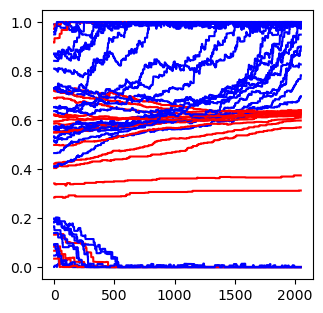

In [5]:
fig, axes = plt.subplots(figsize = (3.5,3.5))

for u in range(N):
    axes.plot(X[:,u], color = "red" if roles[u] else "blue")
fig.show()

## Model

In [6]:
def initialize_training(X, edges, roles, rho = 32):
    T, N = X.shape
    _,edge_per_t,_ = edges.shape
    
    u,v,s_plus,s_minus,t = _BC_roles.convert_edges_uvst(edges)
    s_plus = jnp.float32(s_plus)
    s_minus = jnp.float32(s_minus)
    diff_X = X[t,u] - X[t,v]
    
    return {"u": u, "v": v, "s_plus": s_plus, "s_minus": s_minus, "t": t, "diff_X": diff_X, "N": N, "rho": rho}

def model(data):
    diff_X,u,v,s_plus, s_minus,t, rho, N = [data[k] for k in ["diff_X","u","v","s_plus", "s_minus","t", "rho", "N"]]
    dim = N + 4
    dist = distributions.Normal(jnp.zeros(dim), jnp.ones(dim)).to_event(1)
    params = numpyro.sample("theta", dist)
    
    theta = params[:4]
    epsilon_plus_F, epsilon_plus_L, epsilon_minus_F, epsilon_minus_L = sigmoid(theta) / 2 + jnp.array([0.,0.,.5,.5])

        
    param_roles = params[4:]
    roles_sample = numpyro.sample("roles", distributions.RelaxedBernoulli(probs = param_roles, temperature = jnp.array([0.1])).to_event(1))
    roles_v = roles_sample[v]
        
    # diff_X = jnp.array(diff_X)
    # s_plus = jnp.array(s_plus)
    # s_minus = jnp.array(s_minus)

    epsilon_plus_r = (1 - roles_v) * epsilon_plus_F + roles_v * epsilon_plus_L
    epsilon_minus_r = (1 - roles_v) * epsilon_minus_F + roles_v * epsilon_minus_L
    kappas_plus = _BC_roles.kappa_plus_from_epsilon(epsilon_plus_r, diff_X, rho, with_jax = True)
    kappas_minus = _BC_roles.kappa_minus_from_epsilon(epsilon_minus_r, diff_X, rho, with_jax = True)
    kappas_ = jnp.concatenate([kappas_minus, kappas_plus])
    s = jnp.concatenate([s_minus, s_plus])

    with numpyro.plate("data", s.shape[0]):
        numpyro.sample("obs", distributions.Bernoulli(probs = kappas_), obs = s)

## SVI

In [16]:
# guide = AutoNormal(model)
guide = autoguide.AutoBNAFNormal(model)

data = initialize_training(jnp.array(X), jnp.array(edges), jnp.array(roles))
optimizer = Adam(step_size = 0.01)
svi = SVI(model, guide, optimizer, loss = Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), 400, data)

100%|██████████| 400/400 [00:17<00:00, 22.44it/s, init loss: 8359.3486, avg. loss [381-400]: 4043.8438]


In [17]:
NF_samples = guide.sample_posterior(random.PRNGKey(2), svi_results.params, sample_shape = (50,))

In [19]:
sigmoid(NF_samples["theta"].mean(axis = 0)[:4]) / 2 + jnp.array([0.,0.,.5,.5]), epsilon_plus, epsilon_minus

(Array([0.14962403, 0.35727358, 0.84363484, 0.74799645], dtype=float32),
 array([0.35, 0.15]),
 array([0.75, 0.85]))

In [8]:
svi_params_exp = svi_results.params.copy()

In [19]:
len(svi_params_exp['auto_arn__0$params'])

5

In [ ]:
svi_epsilon_samples = jnp.concatenate([(sigmoid(distributions.Normal(loc = svi_params_exp["theta_auto_loc"][:4], 
                                                             scale = svi_params_exp["theta_auto_scale"][:4]).sample(random.PRNGKey(1))) / 2 + jnp.array([0.,0.,.5,.5]))[:,None] for _ in range(1000)], axis = 1)
epsilon_mean = svi_epsilon_samples.mean(axis = 1)# svi_epsilon_samples.std(axis = 1)
epsilon_real = jnp.concatenate([jnp.array(epsilon_plus), jnp.array(epsilon_minus)])
epsilon_mean, epsilon_real, (jnp.abs(epsilon_mean - epsilon_real) ** 2).mean()

In [32]:
svi_params_exp = svi_results.params.copy()

if svi_params_exp["roles_auto_loc"].mean() > 0:
    svi_params_exp["theta_auto_loc"] = svi_params_exp["theta_auto_loc"].at[jnp.arange(4)].set(svi_params_exp["theta_auto_loc"][jnp.array([1,0,3,2])])
    svi_params_exp["roles_auto_loc"] = -svi_params_exp["roles_auto_loc"]

print("correct epsilon", jnp.concatenate([epsilon_plus, epsilon_minus]))
print("estimated epsilon", (sigmoid(svi_params_exp["theta_auto_loc"])[:4] / 2 + jnp.array([0.,0.,.5,.5])).round(3))

print("correct roles", (sigmoid(svi_params_exp["roles_auto_loc"]).round() == roles).sum())

correct epsilon [0.35 0.15 0.75 0.85]
estimated epsilon [0.35900003 0.142      0.748      0.84900004]
correct roles 200


In [39]:
sigmoid(svi_params_exp["roles_auto_loc"]).round() == roles

Array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [87]:
svi_results7 = svi.run(random.PRNGKey(0), 16000, data, init_state = svi_results6.state)

100%|██████████| 16000/16000 [02:19<00:00, 114.94it/s, init loss: 39165.2266, avg. loss [15201-16000]: 38309.5312]


In [88]:
svi_samples = svi_results7.params.copy()
if svi_samples["roles_auto_loc"].mean() > 0:
    svi_samples["theta_auto_loc"] = svi_samples["theta_auto_loc"].at[jnp.arange(4)].set(svi_samples["theta_auto_loc"][jnp.array([1,0,3,2])])
    svi_samples["roles_auto_loc"] = -svi_samples["roles_auto_loc"]

print("correct epsilon", jnp.concatenate([epsilon_plus, epsilon_minus]))
print("estimated epsilon", (sigmoid(svi_samples["theta_auto_loc"])[:4] / 2 + jnp.array([0.,0.,.5,.5])).round(3))

print("correct roles", (sigmoid(svi_samples["roles_auto_loc"]).round() == roles).sum())

correct epsilon [0.25 0.15 0.55 0.85]
estimated epsilon [0.24400002 0.263      0.564      0.52500004]
correct roles 3236


## MCMC

In [21]:
mcmc = MCMC(NUTS(model), num_warmup = 50, num_samples = 50)
mcmc.run(random.PRNGKey(0), data)

sample: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it, 1023 steps of size 3.54e-04. acc. prob=0.96]


In [30]:
(sigmoid(mcmc.get_samples()["roles"]).mean(axis = 0).round() == roles).sum()

Array(20, dtype=int32)

In [129]:
mcmc_samples = mcmc.get_samples()
if mcmc_samples["roles"].mean() > 0:
    mcmc_samples["theta"] = mcmc_samples["theta"].at[jnp.arange(4)].set(mcmc_samples["theta"][jnp.array([1,0,3,2])])
    mcmc_samples["roles"] = -mcmc_samples["roles"]

print("correct epsilon", jnp.concatenate([epsilon_plus, epsilon_minus]))
print("estimated epsilon", (sigmoid(mcmc_samples["theta"][-1,:4]) / 2 + jnp.array([0.,0.,.5,.5])).round(3))

print("correct roles", (sigmoid(mcmc_samples["roles"][-1]).round() == jnp.array(roles)).sum())

correct epsilon [0.25 0.15 0.55 0.85]
estimated epsilon [0.238      0.252      0.56700003 0.56100005]
correct roles 770


In [100]:
mcmc.post_warmup_state = mcmc.last_state
mcmc.run(mcmc.post_warmup_state.rng_key, data)

sample: 100%|██████████| 50/50 [01:20<00:00,  1.62s/it, 1023 steps of size 3.70e-04. acc. prob=0.97]


In [101]:
mcmc_samples = mcmc.get_samples()
if mcmc_samples["roles"].mean() > 0:
    mcmc_samples["theta"] = -mcmc_samples["theta"]
    mcmc_samples["roles"] = -mcmc_samples["roles"]

print("correct epsilon", jnp.concatenate([epsilon_plus, epsilon_minus]))
print("estimated epsilon", (sigmoid(mcmc_samples["theta"][-1,:4]) / 2 + jnp.array([0.,0.,.5,.5])).round(3))

print("correct roles", (sigmoid(mcmc_samples["roles"][-1]).round() == jnp.array(roles)).sum())

correct epsilon [0.25 0.15 0.55 0.85]
estimated epsilon [0.28300002 0.23300001 0.846      0.998     ]
correct roles 570


## Complete Experiment


In [ ]:
import _inference_roles
reload(_inference_roles)

In [170]:
mcmc_samples = mcmc.get_samples()
epsilon_samples = sigmoid(mcmc_samples["theta"][:,:4]) / 2 + jnp.array([0.,0.,.5,.5])
epsilon_mean, epsilon_std = epsilon_samples.mean(axis = 0), epsilon_samples.std(axis = 0)
mcmc_samples_roles = sigmoid(mcmc_samples["roles"]).round()

In [181]:
# res_svi[-1], res_mcmc[-1]
res_mcmc[-1]["roles_est"].mean(axis = 0).round()

Array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [183]:
res_svi[0].keys()

dict_keys(['n_steps', 'epsilon_mean', 'epsilon_std', 'roles_est'])

In [204]:
epsilons = jnp.concatenate([epsilon_plus, epsilon_minus])
roles_est = res_svi[0]["roles_est"]
epsilon_mean = res_svi[0]["epsilon_mean"]
epsilon_std = res_svi[0]["epsilon_std"]

epsilon_names = ["epsilon_F_plus", "epsilon_L_plus", "epsilon_F_minus", "epsilon_L_minus"]
out = {
        "mse_epsilon": ((epsilons - epsilon_mean)**2).mean().item(), 
        "accuracy_roles": ((roles_est == roles) + 0.).mean().item(),
        "correct_leaders": (((roles_est == 1)&(roles == 1)).sum() / (roles == 1).sum()).item(),
        "correct_followers": (((roles_est == 0)&(roles == 0)).sum() / (roles == 0).sum()).item()}

out.update({u + "_error": np.abs(epsilons[k] - epsilon_mean[k]) for k, u in enumerate(epsilon_names)})
out.update({u + "_mean": epsilon_mean[k].item() for k, u in enumerate(epsilon_names)})
out.update({u + "_std": epsilon_std[k].item() for k, u in enumerate(epsilon_names)})
out.update({u + "_real": epsilons[k].item() for k, u in enumerate(epsilon_names)})

        # "epsilon_F_plus_error": np.abs(epsilons[0] - epsilon_mean[0]).item(),
        # "epsilon_L_plus_error": np.abs(epsilons[1] - epsilon_mean[1]).item(),
        # "epsilon_F_minus_error": np.abs(epsilons[2] - epsilon_mean[2]).item(), 
        # "epsilon_L_minus_error": np.abs(epsilons[3] - epsilon_mean[3]).item(),
        # "epsilon_F_plus_mean": epsilon_mean[0].item(), 
        # "epsilon_L_plus_mean": epsilon_mean[1].item(), 
        # "epsilon_F_minus_mean": epsilon_mean[2].item(), 
        # "epsilon_L_minus_mean": epsilon_mean[3].item(),
        # "epsilon_F_plus_std": epsilon_std[0].item(), 
        # "epsilon_L_plus_std": epsilon_std[1].item(),
        # "epsilon_F_minus_std": epsilon_std[2].item(), 
        # "epsilon_L_minus_std": epsilon_std[3].item(), 
        # "epsilon_F_plus_real": epsilons[0].item(),
        # "epsilon_L_plus_real": epsilons[1].item(), 
        # "epsilon_F_minus_real": epsilons[2].item(), 
        # "epsilon_L_minus_real": epsilons[3].item(),
        # # "tot_time": tot_time
        #    }

In [250]:
experiment = _inference_roles.complete_experiment(200, 2**11, 6, 20, n_steps = 200, intermediate_steps = 100, n_samples = 20, intermediate_samples = 10)

{'pos_interactions_L_plus': 143, 'pos_interactions_L_minus': 216, 'pos_interactions_F_plus': 4245, 'pos_interactions_F_minus': 3933, 'tot_interactions_L': 1229, 'tot_interactions_F': 11053, 'T': 2048, 'N': 200, 'edge_per_t': 6, 'initial_leaders': 20, 'initial_leaders_ratio': 10.0}
{'mse_epsilon': 0.004983415827155113, 'accuracy_roles': 0.6649999618530273, 'correct_leaders': 0.44999998807907104, 'correct_followers': 0.6888889074325562, 'tot_time': 5.333198070526123, 'n_steps': 200, 'n_samples': None, 'epsilon_F_plus_error': 0.0057273507, 'epsilon_L_plus_error': 0.1390743, 'epsilon_F_minus_error': 0.0065497756, 'epsilon_L_minus_error': 0.022722244, 'epsilon_F_plus_mean': 0.2557273507118225, 'epsilon_L_plus_mean': 0.1890742927789688, 'epsilon_F_minus_mean': 0.5434502363204956, 'epsilon_L_minus_mean': 0.7727222442626953, 'epsilon_F_plus_std': 2.9802322387695312e-08, 'epsilon_L_plus_std': 0.0, 'epsilon_F_minus_std': 5.960464477539063e-08, 'epsilon_L_minus_std': 0.0, 'epsilon_F_plus_real': 0

In [252]:
import pandas as pd

In [253]:
pd.DataFrame(experiment)

,mse_epsilon,accuracy_roles,correct_leaders,correct_followers,tot_time,n_steps,n_samples,epsilon_F_plus_error,epsilon_L_plus_error,epsilon_F_minus_error,...,pos_interactions_L_minus,pos_interactions_F_plus,pos_interactions_F_minus,tot_interactions_L,tot_interactions_F,T,N,edge_per_t,initial_leaders,initial_leaders_ratio
0,0.004983,0.665,0.45,0.688889,2.763944,100.0,NaN,0.005727,0.139074,0.006550,...,216,4245,3933,1229,11053,2048,200,6,20,10.0
1,0.004983,0.665,0.45,0.688889,5.333198,200.0,NaN,0.005727,0.139074,0.006550,...,216,4245,3933,1229,11053,2048,200,6,20,10.0
2,0.028227,0.900,0.00,1.000000,7.340589,NaN,10.0,0.120893,0.249712,0.049818,...,216,4245,3933,1229,11053,2048,200,6,20,10.0
3,0.048419,0.900,0.00,1.000000,13.928906,NaN,20.0,0.204921,0.238131,0.192505,...,216,4245,3933,1229,11053,2048,200,6,20,10.0


In [263]:
np.array([50, 100, 200, 400, 800, 1600, 3200, 6400]) / 50

array([  1.,   2.,   4.,   8.,  16.,  32.,  64., 128.])

In [260]:
np.random.randint(low = 0,high = 10**14)

11603175116033

In [6]:
import pandas as pd
import glob

In [17]:
df = pd.concat([pd.DataFrame(pd.read_pickle(file)) for file in glob.glob("../data/mcmc_svi_leaders_240105/*")])

In [18]:
df.groupby(["id", "method"]).last()

mse_epsilon  accuracy_roles  correct_leaders  \
id             method                                                 
5879553518497  mcmc       0.009498           0.790            0.000   
               svi        0.000904           0.785            0.825   
41327402083982 mcmc       0.028963           0.910            0.000   
               svi        0.022809           0.640            1.000   
44784918104876 mcmc       0.127087           0.710            0.000   
               svi        0.002014           0.970            1.000   
62847535776383 mcmc       0.000218           0.830            0.150   
               svi        0.001157           1.000            1.000   
83285901897161 mcmc       0.004444           0.680            0.400   
               svi        0.004493           0.620            0.000   
85452608403086 mcmc       0.003970           0.780            0.500   
               svi        0.008921           0.640            0.500   
92216277537366 mcmc       0.023812           0.640            0.000   
               svi        0.022528           0.620            0.600   
97743169885930 mcmc       0.026001           0.800            0.000   
               svi        0.021123           0.680            0.500   

                       correct_followers   tot_time  n_steps  n_samples  \
id             method                                                     
5879553518497  mcmc             0.987500  62.249071      NaN      200.0   
               svi              0.775000  66.089689  10000.0        NaN   
41327402083982 mcmc             0.919192  59.819994      NaN      200.0   
               svi              0.636364  72.234719  10000.0        NaN   
44784918104876 mcmc             0.788889  56.033143      NaN      200.0   
               svi              0.966667  70.870051  10000.0        NaN   
62847535776383 mcmc             1.000000  58.502240      NaN      200.0   
               svi              1.000000  68.899508  10000.0        NaN   
83285901897161 mcmc             0.711111  60.072796      NaN      200.0   
               svi              0.688889  69.910742  10000.0        NaN   
85452608403086 mcmc             0.791667  59.954882      NaN      200.0   
               svi              0.645833  74.330895  10000.0        NaN   
92216277537366 mcmc             0.800000  55.360477      NaN      200.0   
               svi              0.625000  75.005767  10000.0        NaN   
97743169885930 mcmc             0.833333  55.625996      NaN      200.0   
               svi              0.687500  68.398868  10000.0        NaN   

                       epsilon_F_plus_error  epsilon_L_plus_error  \
id             method                                               
5879553518497  mcmc                0.015268              0.075525   
               svi                 0.009644              0.015405   
41327402083982 mcmc                0.031399              0.314673   
               svi                 0.050383              0.231533   
44784918104876 mcmc                0.308855              0.306536   
               svi                 0.025931              0.031438   
62847535776383 mcmc                0.011836              0.004908   
               svi                 0.043528              0.002604   
83285901897161 mcmc                0.005630              0.083249   
               svi                 0.021714              0.113635   
85452608403086 mcmc                0.011242              0.090369   
               svi                 0.010009              0.098330   
92216277537366 mcmc                0.084456              0.105698   
               svi                 0.010866              0.070961   
97743169885930 mcmc                0.056784              0.222200   
               svi                 0.037322              0.250580   

                       epsilon_F_minus_error  ...  pos_interactions_L_minus  \
id             method                         ...                      

In [5]:
import _inference_leaders

In [6]:
from importlib import reload

In [14]:
out = _inference_roles.complete_experiment(N = 100, T = 128, initial_leaders = 10, 
                                           n_steps = 2000, save_data = False,
                                           edge_per_t = 10, method = "abc")

In [11]:
out

[{'id': None,
  'method': 'svinormal',
  'mse_epsilon': 0.0017006585840135813,
  'accuracy_roles': 1.0,
  'correct_leaders': 1.0,
  'correct_followers': 1.0,
  'est_leaders': 10.0,
  'tot_time': 15.732280254364014,
  'n_steps': 2000,
  'n_samples': None,
  'epsilon_F_plus_error': 0.014016867,
  'epsilon_L_plus_error': 0.010055438,
  'epsilon_F_minus_error': 0.004978895,
  'epsilon_L_minus_error': 0.08050007,
  'epsilon_F_plus_mean': 0.464016854763031,
  'epsilon_L_plus_mean': 0.03994456306099892,
  'epsilon_F_minus_mean': 0.545021116733551,
  'epsilon_L_minus_mean': 0.869499921798706,
  'epsilon_F_plus_std': 0.004839463625103235,
  'epsilon_L_plus_std': 0.010410690680146217,
  'epsilon_F_minus_std': 0.005245825741440058,
  'epsilon_L_minus_std': 0.02289312332868576,
  'epsilon_F_plus_real': 0.44999998807907104,
  'epsilon_L_plus_real': 0.05000000074505806,
  'epsilon_F_minus_real': 0.550000011920929,
  'epsilon_L_minus_real': 0.949999988079071,
  'pos_interactions_L_plus': 9,
  'pos_in

In [13]:
import pandas as pd